In [5]:
# Stack Exchange post : https://quant.stackexchange.com/questions/60372/comparison-of-results-given-by-volatility-estimators-garman-klass-vs-garch1-1
import math
import pandas as pd 
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt
from datetime import date 
import yfinance as yf
from arch import arch_model
from collections import OrderedDict

In [6]:
observation_period=10 # number of months from the last available day
df =  yf.download("TSLA")
df=df.last('%dm'%observation_period)

def annualized_realized_volatility_estimator(df,window_length=observation_period, unit_window_length='m', A=252):
    temp=A*(1/len(df))*np.log(df.last('%d'%observation_period+unit_window_length)).diff().dropna()
    V=temp['Adj Close'].sum() 
    return math.sqrt(V)


def Garman_Klass_estimator_row(H, L, O, C,T=len(df.index), A=252):
    V=A*(1/T)*(1/2)*(math.log(H/L))**2 - (2*math.log(2)-1)*(math.log(C/O))**2
    return V
def Garman_Klass_estimator(df):
    vol=math.sqrt(df.apply(lambda row:Garman_Klass_estimator_row(row['High'], row['Low'], row['Open'], row['Close']),axis=1).sum())
    return vol


def Garch_model(df,training_period,observation_period,horizon=1): #training_period is the number of months for training the Garch
    df_garch=df.last('%dm'%(observation_period+training_period))
    df_garch_train=df_garch.first('%dm'%training_period)
    df_garch_predict=df_garch.last('%dm'%observation_period)
    df_garch_train.loc[:,'Returns']=100 * df_garch_train.loc[:,'Adj Close'].pct_change().dropna()
    garch11 = arch_model(df_garch_train.loc[:,'Returns'].dropna(), p=1, q=1) 
    res = garch11.fit(update_freq=10) 
    forecasts = res.forecast(horizon=horizon)
    return 0.1*forecasts.residual_variance.iloc[-1].values[-1]

[*********************100%***********************]  1 of 1 completed


In [7]:
# get directories of files
d_root = "C:/Users/Keegan/OneDrive/1 Studies/2021 - 2022/5003W/3 - Dissertation/5-Data/multi_series_data/intraday/clean/longest/"
files = os.listdir(d_root)
dirs = [d_root + x for x in files]

keys = [a.removesuffix("_intra_clean.xlsx") for a in files]
keys = [a.removesuffix("_index_clean.xlsx") for a in keys]

if len(files) == len(keys):
    exit
else:
    raise error("Object did not retain length. Check processing for errors.")

In [8]:
data = OrderedDict()
for i in range(len(dirs)):
    open(dirs[i])
    data[keys[i]] = pd.read_excel(dirs[i])

cols = list(data[keys[0]].columns)

length = []
for i in range(len(keys)):
    length.append(len(data[keys[i]]))
print("total number of observations in all data: ", sum(length)*4)

total number of observations in all data:  3249852


In [15]:
keys

['as51',
 'cac',
 'dax',
 'ftsemib',
 'hsi',
 'ibex',
 'ibov',
 'jalsh',
 'jci',
 'kospi',
 'merval',
 'mexbol',
 'moex',
 'n100',
 'nifty',
 'nky',
 'saseidx',
 'shsz300',
 'sptsx',
 'spx',
 'ukx',
 'xu100']

In [41]:
df_ukx = data['ukx'].copy() #.set_index('Date')

In [38]:
vol = Garman_Klass_estimator(df_ukx)

TypeError: cannot convert the series to <class 'float'>

In [37]:
def Garman_Klass_estimator_row(H, L, O, C,T=len(df.index), A=252):
    V=A*(1/T)*(1/2)*(math.log(H/L))**2 - (2*math.log(2)-1)*(math.log(C/O))**2
    return V
def Garman_Klass_estimator(df):
    # vols = pd.Series()
    vol=math.sqrt(df.apply(lambda row:Garman_Klass_estimator_row(row['High'], row['Low'], row['Open'], row['Close']),axis=1)) # .sum()
    return vol

In [57]:
def gk_vol(df):
    D = df.Date
    H = df.High
    L = df.Low
    O = df.Open
    C = df.Close
    time = len(df.Date)
    df_c = df.copy(deep='True')
    vol = list()
    for i in range(len(df)):
        row = df.iloc[i]
        row_vol = math.sqrt(Garman_Klass_estimator_row(H=row.High,L=row.Low,O=row.Open,C=row.Close))
        vol.append(row_vol)
    vol = pd.Series(vol)
    vol.name = "gk_vol"
    return pd.concat([df_c, vol], axis=1)

In [47]:
df_ukx.iloc[1].Open

7257.54

In [58]:
gk_test = gk_vol(df_ukx)

In [59]:
gk_test

,Date,Open,High,Low,Close,gk_vol
0,2022-03-03 11:30:00,7238.85,7238.85,7238.85,7238.85,0.000000
1,2022-03-03 11:00:00,7257.54,7262.14,7231.51,7237.78,0.002895
2,2022-03-03 10:30:00,7305.34,7305.34,7257.54,7257.62,0.003249
3,2022-03-03 10:00:00,7335.01,7335.08,7301.41,7305.43,0.002651
4,2022-03-03 09:30:00,7343.24,7351.84,7326.33,7334.98,0.002669
...,...,...,...,...,...,...
48072,2011-07-14 05:00:00,5875.79,5882.27,5867.35,5873.10,0.001996
48073,2011-07-14 04:30:00,5875.73,5882.67,5872.25,5875.86,0.001407
48074,2011-07-14 04:00:00,5875.01,5875.65,5869.56,5875.65,0.000820
48075,2011-07-14 03:30:00,5873.27,5885.19,5873.20,5875.09,0.001607


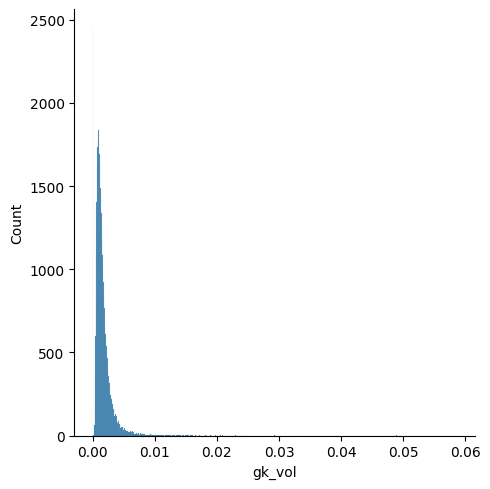

In [60]:
import seaborn as sns
sns.displot(gk_test.gk_vol)